In [372]:
from __future__ import division


#https://python-chess.readthedocs.io/en/latest/
import chess, random
from mcts import mcts
from chess import Move, svg
from IPython.display import display


from copy import deepcopy
from mcts import mcts
from functools import reduce
import operator
from stockfish import Stockfish


In [373]:
BLACK = -1
WHITE = 1

class ChessState():
    def __init__(self):
        self.board = chess.Board()
        self.currentPlayer = 1
    def getCurrentPlayer(self):
        # 1 for maximiser, -1 for minimiser
        return self.currentPlayer

    def getLegalActions(self):
        legal_actions = list(self.board.legal_moves)
        result = []
        for a in legal_actions:
            result.append(Action(a.uci()))
        return result

    def generateSuccessor(self, action):
        if action is not None:
        
            newState = deepcopy(self)
            try:
                newState.board.push(Move.from_uci(action.uci))
            except:
                print("Illegal Move")
                display(svg.board(newState.board, size=100)) 
                return None
            
            newState.currentPlayer = -1 * newState.currentPlayer
            return newState
        return self

    def isTerminal(self):
        return self.board.is_game_over()
    
    def isWin(self):
        if self.isTerminal():
            res = self.board.result()
            if res == "1-0":
                return True
            else:
                return False
        else:
            return False
    
    def isLose(self):
        if self.isTerminal():
            return not self.isWin()
        else:
            return False
    
    #DRAWS
    
    def getReward(self):
        # only needed for terminal states
        if self.isTerminal():
            res = self.board.result()
            if res == "1-0":
                return 1
            elif res == "0-1":
                return -1
            else:
                return 0
        else:
            return 0
        
    

In [374]:
class Action():
    def __init__(self, uci):
        self.uci = uci
    def __hash__(self):
        return hash(self.uci)
    def __str__(self):
        return self.uci
    def __repr__(self):     
        return self.uci

In [375]:
from abc import ABC, abstractmethod
class Agent(ABC):
    @abstractmethod
    def getAction(self, possible_actions):
        pass

In [376]:
class RandomAgent(Agent):
    def getAction(self, possible_actions):
        return random.choice(possible_actions)

In [377]:
import random


class ReflexAgent(Agent):
    """
    A reflex agent chooses an action at each choice point by examining
    its alternatives via a state evaluation function.
    The code below is provided as a guide.  You are welcome to change
    it in any way you see fit, so long as you don't touch our method
    headers.
    """

    def getAction(self, gameState):
        """
        You do not need to change this method, but you're welcome to.
        getAction chooses among the best options according to the evaluation function.
        Just like in the previous project, getAction takes a GameState and returns
        some Directions.X for some X in the set {NORTH, SOUTH, WEST, EAST, STOP}
        """
        # Collect legal moves and successor states
        legalMoves = gameState.getLegalActions()

        # Choose one of the best actions
        scores = [self.evaluationFunction(gameState, action) for action in legalMoves]
        bestScore = max(scores)
        bestIndices = [index for index in range(len(scores)) if scores[index] == bestScore]
        chosenIndex = random.choice(bestIndices)  # Pick randomly among the best

        "Add more of your code here if you want to"

        return legalMoves[chosenIndex]

    def evaluationFunction(self, currentGameState, action):
    
        return scoreEvaluationFunction(currentGameState.generateSuccessor(action))
    #         [1, 3, 3, 5, 9, 0]
        


def scoreEvaluationFunction(currentGameState):
    """
    This default evaluation function just returns the score of the state.
    The score is the same one displayed in the Pacman GUI.
    This evaluation function is meant for use with adversarial search agents
    (not reflex agents).
    """
    score = 0
    fen = currentGameState.board.fen()
    piece_values = {'p': -1, 'P': 1, 'k': 0, 'K': 0, 'n': -3, 'N':3, 'b': -3, 'B':3, 'r': -5, 'R':5, 'q': -9, 'Q': 9}
    
    def get_value(char):
        try:
            return piece_values[char]
        except:
            return 0
    for i in range(fen.index(" ")):
        score+=get_value(fen[i])
        
    return score


class MultiAgentSearchAgent(Agent):
    """
    This class provides some common elements to all of your
    multi-agent searchers.  Any methods defined here will be available
    to the MinimaxPacmanAgent, AlphaBetaPacmanAgent & ExpectimaxPacmanAgent.
    You *do not* need to make any changes here, but you can if you want to
    add functionality to all your adversarial search agents.  Please do not
    remove anything, however.
    Note: this is an abstract class: one that should not be instantiated.  It's
    only partially specified, and designed to be extended.  Agent (game.py)
    is another abstract class.
    """

    def __init__(self, evalFn=scoreEvaluationFunction, depth='1'):
        self.index = 0  # Pacman is always agent index 0
        self.evaluationFunction = evalFn
        self.depth = int(depth)


class MinimaxAgent(MultiAgentSearchAgent):
    
    def min_value(self,state, depth):
        v = float("inf")
        best_action_indices = []
        actions = state.getLegalActions()

        if state.isWin() or state.isLose():
            return self.evaluationFunction(state), None

        if depth >= self.depth:
            for action_index in range(len(actions)):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state)
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                 
            return v, actions[random.choice(best_action_indices)]
        else:
            for action_index in range(len(actions)):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.max_value(successor_state, depth + 1)[0]
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                    
            return v, actions[random.choice(best_action_indices)]

    def max_value(self,state, depth):
        v = float("-inf")
        best_action_indices = []
        actions = state.getLegalActions()
        if state.isWin() or state.isLose() :
            return self.evaluationFunction(state), None
        if depth >= self.depth :

            for action_index in range(len(actions)):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state)
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
            return v, actions[random.choice(best_action_indices)]
        else :
            for action_index in range(len(actions)):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.min_value(successor_state, depth)[0]
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
            return v, actions[random.choice(best_action_indices)]
        
    def getAction(self, gameState):
        if gameState.currentPlayer == 1 :
            return self.max_value(gameState, 0)[1]
        if gameState.currentPlayer == -1 :
            return self.min_value(gameState, 0)[1]


In [378]:
class AlphaBetaAgent(MultiAgentSearchAgent):
    """
    Your minimax agent with alpha-beta pruning (question 3)
    """

    def min_value(self,state, depth, alpha, beta):
        v = float("inf")
        best_action_indices = [0]
        actions = state.getLegalActions()
        #actions = random.sample(actions, len(actions)//2)
        #print(len(actions))

        if state.isWin() or state.isLose():
            return self.evaluationFunction(state), None

        if depth >= self.depth:
            for action_index in random.sample(range(len(actions)), k = len(actions)//4):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state)
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                 
            return v, actions[random.choice(best_action_indices)]
        else:
            currentBeta = beta
            for action_index in random.sample(range(len(actions)), k = len(actions)//4):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.max_value(successor_state, depth + 1, alpha, currentBeta)[0]
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                if v < alpha:
                    return v, actions[random.choice(best_action_indices)]
                currentBeta = min(currentBeta, v)
                    
            return v, actions[random.choice(best_action_indices)]

    def max_value(self,state, depth, alpha, beta):
        v = float("-inf")
        best_action_indices = [0]
        actions = state.getLegalActions()
        
        #actions = random.sample(actions, len(actions)//2)
        #print(len(actions))

        if state.isWin() or state.isLose() :
            return self.evaluationFunction(state), None
        if depth >= self.depth :
            for action_index in random.sample(range(len(actions)), k = len(actions)//4):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state)
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
    
            return v, actions[random.choice(best_action_indices)]
        else :
            currentAlpha = alpha
            for action_index in random.sample(range(len(actions)), k = len(actions)//4):
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.min_value(successor_state, depth, currentAlpha, beta)[0]
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                if v > beta:
                    #WHATTTT
                    return v, actions[random.choice(best_action_indices)]
                currentAlpha = max(currentAlpha, v)
            return v, actions[random.choice(best_action_indices)]
        
    def getAction(self, gameState):
        
        if gameState.currentPlayer == 1 :
            return self.max_value(gameState, 0, float("-inf"), float("inf"))[1]
        if gameState.currentPlayer == -1 :
            return self.min_value(gameState, 0, float("-inf"), float("inf"))[1]


In [379]:
# import time

# print("AlphaBeta starting")
# agent = AlphaBetaAgent()
# start_time = time.time()
# gameplay(agent)
# print("--- %s seconds ---" % (time.time() - start_time))



In [380]:
def alphabeta(position, depth, alpha, beta):
    """Returns a tuple (score, bestmove) for the position at the given depth"""
    if depth == 0 or position.is_checkmate() or position.is_draw():
        return (position.evaluate(), None)
    else: 
        if position.to_move == "white":
            bestmove = None
            for move in position.legal_moves():
                new_position = position.make_move(move)
                score, move = alphabeta(new_position, depth - 1, alpha, beta)
                if score > alpha: # white maximizes her score
                    alpha = score
                    bestmove = move
                    if alpha >= beta: # alpha-beta cutoff
                        break
            return (alpha, bestmove)
        else:
            bestmove = None
            for move in position.legal_moves():
                new_position = position.make_move(move)
                score, move = alphabeta(new_position, depth - 1, alpha, beta)
                if score < beta: # black minimizes his score
                    beta = score
                    bestmove = move
                    if alpha >= beta: # alpha-beta cutoff
                        break
            return (beta, bestmove)

In [381]:
#https://www.chessprogramming.org/PeSTO%27s_Evaluation_Function
#piece square table, mid game, end game

In [382]:
from joblib import dump, load
from evaluation_code import *

In [383]:
# model = load("../models/clf_FINAL.save")
# scaler = load("../models/scaler_FINAL.save")
model = load("../models/clf_FINAL_Lite.save")

# ve = VectorEvaluator()
ve_lite = VectorEvaluatorLite()

In [384]:
def apply_vector(gameState) :
   
    player = gameState.getCurrentPlayer()

    if player == -1 :
        player = False
    else :
        player = True
    
    white_scores = ve.apply(gameState.board,True)
    black_scores = ve.apply(gameState.board, False)
    
    diff_scores = [white_scores[i] - black_scores[i] for i in range(len(white_scores))]
    
    white_scores.extend(diff_scores)
    white_scores.extend(black_scores)
    
#     scaler = load('scaler.save')
    
    return scaler.transform([white_scores])

In [385]:
def apply_vector_lite(gameState) :
   
    player = gameState.getCurrentPlayer()

    if player == -1 :
        player = False
    else :
        player = True
    scores = []
    #matsum, piecesquares, hasqueen
    #['W_piece squares sum', 'DIFF_material sum', 'DIFF_piece squares sum', 'DIFF_has queen', 'B_piece squares sum']
    white_scores = ve_lite.apply(gameState.board,True)
    black_scores = ve_lite.apply(gameState.board, False)


    diff_scores = [white_scores[i] - black_scores[i] for i in range(len(white_scores))]
    
    assert len(diff_scores) == len(white_scores) == len(black_scores) == 3

    
    scores.append(white_scores[1])
    scores.append(diff_scores[0])
    scores.append(diff_scores[1])
    scores.append(diff_scores[2])
    scores.append(black_scores[1])


    assert len(scores) == 5
    
    
    

    
    scaler = load('../models/scaler_FINAL_Lite.save')
    
    return scaler.transform([scores])

In [386]:
class AlphaBetaIntelliAgent(MultiAgentSearchAgent):
    """
    Your minimax agent with alpha-beta pruning (question 3)
    """

    def __init__(self):
        self.prev_actions_white = [None, None]
        self.prev_actions_black = [None, None]
        self.depth = 1

    def evaluationFunction(self, currentGameState, action): 
        if currentGameState is None:
            return 0
#         data = apply_vector(currentGameState)
        data = apply_vector_lite(currentGameState)


        return list(model.predict_proba(data))[0][1]
    
    
      
        
    
    def min_value(self,state, depth, alpha, beta):
        v = float("inf")
        best_action_indices = [0]
        actions = state.getLegalActions()
        new_actions = []
        
        prev_actions = []
        if state.getCurrentPlayer() == -1:
            prev_actions = self.prev_actions_black
        if state.getCurrentPlayer() == 1:
            prev_actions = self.prev_actions_white
        
        
        for action in actions:
            if action not in prev_actions:
                new_actions.append(action)
        actions = new_actions
        
        if len(actions) == 0:
            actions = prev_actions
            
        if state.isWin() or state.isLose():
            return self.evaluationFunction(state, None), None
        
        predictions = []
        top_action_indices =[]
        for action in actions:
            successor_state = state.generateSuccessor(action)
            predictions.append(self.evaluationFunction(successor_state, None))
      
        
        k = min(2, len(predictions) -1)
        pred_copy =  predictions.copy()
        pred_copy.sort()
        x = pred_copy[k]
        
        for i in range(len(predictions)):
            if predictions[i] < x :
                top_action_indices.append(i)
        


        if depth >= self.depth:
            for action_index in top_action_indices:
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state, None)
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                 
            return v, actions[random.choice(best_action_indices)]
        else:
            currentBeta = beta
            for action_index in top_action_indices:
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.max_value(successor_state, depth + 1, alpha, currentBeta)[0]
                if successor_value < v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                if v < alpha:
                    return v, actions[random.choice(best_action_indices)]
                currentBeta = min(currentBeta, v)
                    
            return v, actions[random.choice(best_action_indices)]

    def max_value(self,state, depth, alpha, beta):
        v = float("-inf")
        best_action_indices = [0]
        actions = state.getLegalActions()
        
        
        new_actions = []
        prev_actions = []
        if state.getCurrentPlayer() == -1:
            prev_actions = self.prev_actions_black
        if state.getCurrentPlayer() == 1:
            prev_actions = self.prev_actions_white
        
        
        for action in actions:
            if action not in prev_actions:
                new_actions.append(action)
        actions = new_actions
        
        if len(actions) == 0:
            actions = prev_actions

        
        
        
        predictions = []
        top_action_indices =[]
        for action in actions:
            successor_state = state.generateSuccessor(action)
            predictions.append(self.evaluationFunction(successor_state, None))
      
        pred_copy =  predictions.copy()
    
        

        pred_copy.sort(reverse=True)
        k = min(2, len(pred_copy) -1)
        
    
        x = pred_copy[k]
        
        
        for i in range(len(predictions)):
            if predictions[i] >= x :
                top_action_indices.append(i)
        

        if state.isWin() or state.isLose() :
            return self.evaluationFunction(state, None), None
        if depth >= self.depth :
            for action_index in top_action_indices:
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.evaluationFunction(successor_state, None)
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
    
            return v, actions[random.choice(best_action_indices)]
        else :
            currentAlpha = alpha
            for action_index in top_action_indices:
                action = actions[action_index]
                successor_state = state.generateSuccessor(action)
                successor_value = self.min_value(successor_state, depth, currentAlpha, beta)[0]
                if successor_value > v:
                    v = successor_value
                    best_action_indices = [action_index]
                if successor_value == v:
                    best_action_indices+=[action_index]
                if v > beta:
                    #WHATTTT
                    return v, actions[random.choice(best_action_indices)]
                currentAlpha = max(currentAlpha, v)
            return v, actions[random.choice(best_action_indices)]
        
    def getAction(self, gameState):
        
        for action in gameState.getLegalActions():
            successor_state = gameState.generateSuccessor(action)
            if successor_state.board.is_checkmate():
                return action
        
        
        
        
        if gameState.currentPlayer == 1 :
            act = self.max_value(gameState, 0, float("-inf"), float("inf"))[1]
            self.prev_actions_white[0] = self.prev_actions_white[1]
            self.prev_actions_white[1] = act
            return act
    
        if gameState.currentPlayer == -1 :
            act = self.min_value(gameState, 0, float("inf"), float("-inf"))[1]
            self.prev_actions_black[0] = self.prev_actions_black[1]
            self.prev_actions_black[1] = act
            return act
            
            
            
            
            
            
         

In [387]:
class StockFishAgent:
    def __init__(self):
        self.stockfish = Stockfish(parameters={"Threads": 4, "Minimum Thinking Time": 20})
        self.stockfish.set_elo_rating(50)
        self.stockfish.set_depth(1)
#         self.stockfish.set_skill_level(1)

    def getAction(self,state):
        
        self.stockfish.set_fen_position(state.board.fen())
        return Action(str(self.stockfish.get_best_move()))

In [388]:
class RandomAgent:
   
    def getAction(self,state):
        
        return random.choice(state.getLegalActions())

In [389]:
import time

In [390]:
def gameplay(agent1, agent2):
    b = ChessState()
#    display(svg.board(b.board, size=100)) 
#     white = True
#     for i in range(2):
    i = 0
    start_time = time.time()
    while not b.isTerminal():
        print("move", i)
        
        if i > 100:
            break;
        if(b.getCurrentPlayer() == 1):
            action = agent1.getAction(b)
        else:
            action = agent2.getAction(b)
        b = b.generateSuccessor(action)
#         if i %10 == 0 or i < 10:
        display(svg.board(b.board, size=100)) 
        i+=1
        
    print("time", time.time() - start_time)
    
    display(svg.board(b.board, size=100)) 

    print("winner", b.board.result())
#     print("lose", b.isLose())
    print("stalemate", b.board.is_stalemate())
    

In [391]:
b = AlphaBetaIntelliAgent()
a = AlphaBetaIntelliAgent()
# b = StockFishAgent()
# a = RandomAgent()

move 0


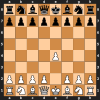

move 1


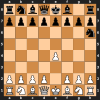

move 2


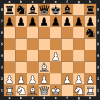

move 3


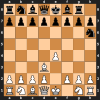

move 4


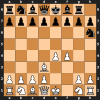

move 5


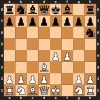

move 6


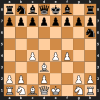

move 7


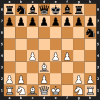

move 8


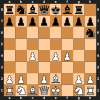

move 9


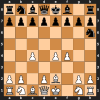

move 10


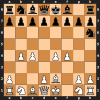

move 11


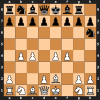

move 12


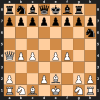

move 13


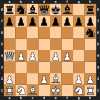

move 14


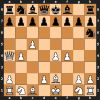

move 15


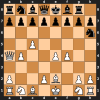

move 16


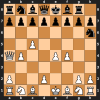

move 17


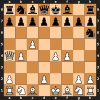

move 18


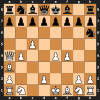

move 19


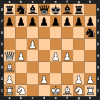

move 20


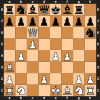

move 21


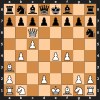

move 22


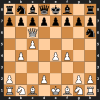

move 23


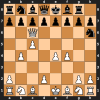

move 24


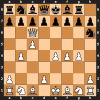

move 25


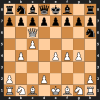

move 26


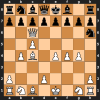

move 27


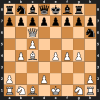

move 28


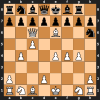

move 29


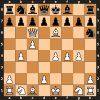

move 30


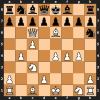

move 31


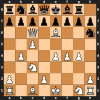

move 32


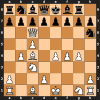

move 33


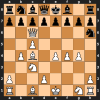

move 34


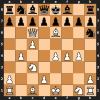

move 35


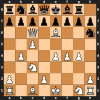

move 36


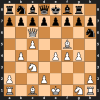

move 37


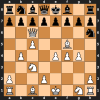

move 38


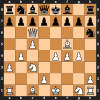

move 39


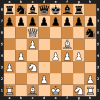

move 40


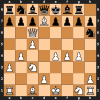

move 41


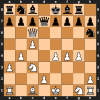

move 42


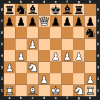

move 43


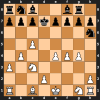

move 44


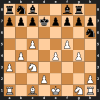

move 45


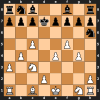

move 46


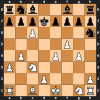

move 47


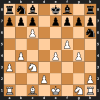

move 48


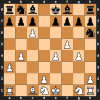

move 49


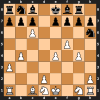

move 50


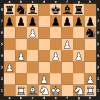

move 51


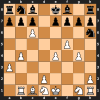

move 52


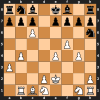

move 53


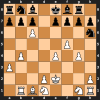

move 54


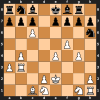

move 55


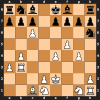

move 56


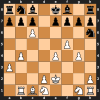

move 57


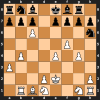

move 58


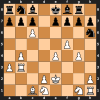

move 59


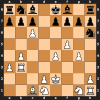

move 60


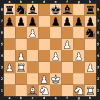

move 61


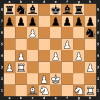

move 62


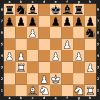

move 63


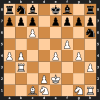

move 64


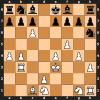

move 65


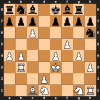

move 66


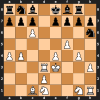

move 67


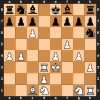

move 68


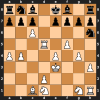

move 69


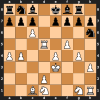

move 70


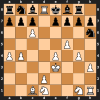

move 71


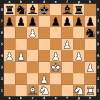

move 72


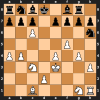

move 73


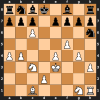

move 74


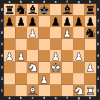

move 75


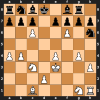

move 76


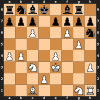

move 77


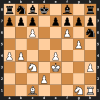

move 78


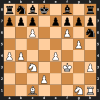

move 79


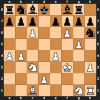

move 80


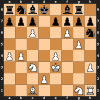

move 81


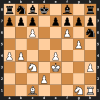

move 82


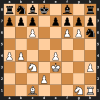

move 83


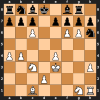

move 84


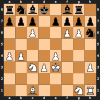

move 85


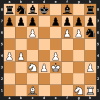

move 86


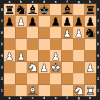

move 87


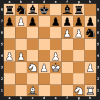

move 88


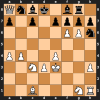

move 89


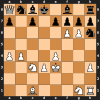

move 90


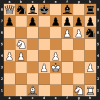

move 91


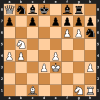

move 92


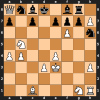

move 93


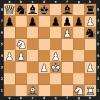

move 94


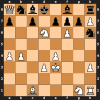

move 95


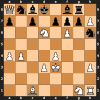

move 96


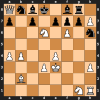

move 97


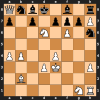

move 98


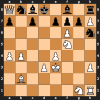

move 99


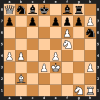

move 100


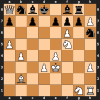

move 101
time 58.67569708824158


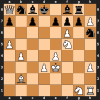

winner *
stalemate False


In [392]:
gameplay(a, b)

In [393]:
brd = chess.Board()

In [394]:
brd.legal_moves

<LegalMoveGenerator at 0x7f9f40ef0d10 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>

In [395]:
brd.push(Move.from_uci("e2e4"))

In [396]:
brd.legal_moves

<LegalMoveGenerator at 0x7f9f40ef0a90 (Nh6, Nf6, Nc6, Na6, h6, g6, f6, e6, d6, c6, b6, a6, h5, g5, f5, e5, d5, c5, b5, a5)>